In [1]:
from __future__ import print_function

import time
from PIL import Image
import numpy as np

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16


from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

Using TensorFlow backend.


## LOADING IMAGES

In [20]:
base_path = "C:/Users/spari/Projects/Machine Learning/BeArtistic/"


content_image_path = base_path+"smiley.jpg"
style_image_path = base_path+"abstract.jpg"

#Set default size (always square for gram matrix calculation)
height = width = 512
channels = 3

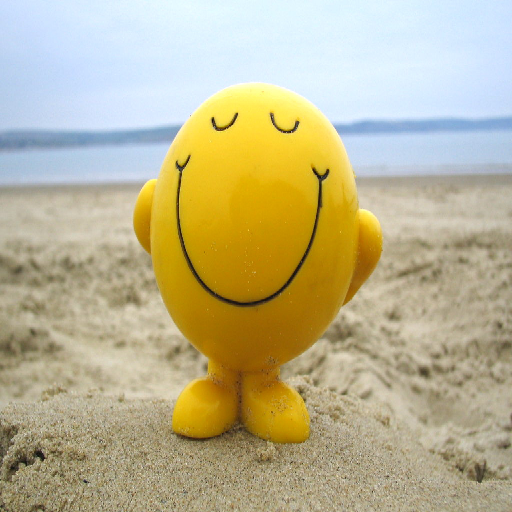

In [12]:
content_image = Image.open(content_image_path)
content_image = content_image.resize((width, height))
content_image

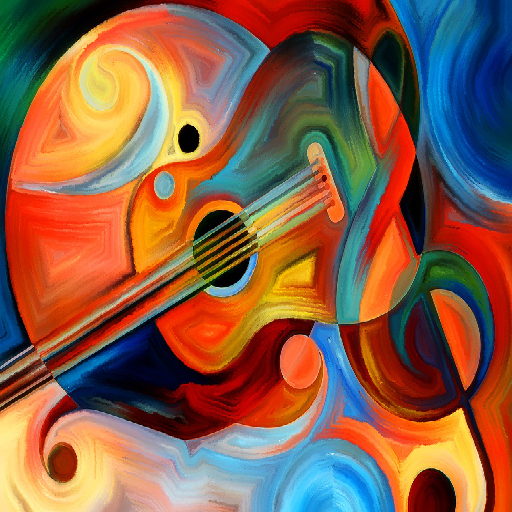

In [16]:
style_image = Image.open(style_image_path)
style_image = style_image.resize((width, height))
style_image

## Creating tensors
Converting image dimensions into suitable ones for numerical processing. Beyond (height x width x channels) another dimension is added as 1 to concatenate these representations into a common tensor

In [18]:
content_array = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)
print(content_array.shape)

style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)
print(style_array.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)


## Preprocessing

1. Subtracting mean RGB value from each pixel.
2. Flip ordering of array from RGB to BGR.

In [19]:
# taken from paper by Simonyan and Zisserman (2015)

content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]

## Keras VGG16 set up

1. Using keras tensorflow backend.
2. Placeholder created to store result image.

In [22]:
# backend.vriable instantiates a variable and return it.
# backend.placeholder instantiates a placeholder tensor and returns it.

content_image = backend.variable(content_array)
style_image = backend.variable(style_array)

result_image = backend.placeholder((1, height, width, channels))


# Concatenate all three to create a single tensor to be sent to VGG16 model.
input_tensor = backend.concatenate([content_image, style_image,result_image], axis=0)

In [23]:
# Create model
model = VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)

In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [25]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1/Relu:0' shape=(3, 64, 64, 512) dtype=float32>,
 'b

## Cost Functions Involved

Style transfer can be talked about as an optimization problem. Here also we want to minimize the loss function but for this case loss function is divided into 3 parts as:
* Content loss
* Style loss
* Total variation loss


### Content Loss
Euclidian distance between feature representation of content image and result image

In [28]:
content_weight = 0.025
style_weight = 5.0
total_variation_weight = 1.0

In [30]:
def content_loss(content, result):
    return backend.sum(backend.square(result - content))

# Layer selected for getting content features
layer_features = layers['block2_conv2']
content_features = layer_features[0, :, :, :]
result_features = layer_features[2, :, :, :]

loss = backend.variable(0.)

loss += content_weight * content_loss(content_features,  result_features)

### Style Loss
Gram matric is calculated. Gram matrix gives covariances of two sets of feature maps. It is a dot product of an image by itself.


Style loss is difference between this gram matrix and the result image

In [33]:
def get_gram(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

In [35]:
def style_loss(style, result):
    Style = get_gram(style)
    Result = get_gram(result)
    
    size = height * width
    return backend.sum(backend.square(Style - Result)) / (4. * (channels ** 2) * (size ** 2))

feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']

for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl

### Total variation loss
Regulization for eliminating noise from the output. 

In [36]:
def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

loss += total_variation_weight * total_variation_loss(result_image)

### Set up Gradients
Set gradients of total loss relative to result image and improve gradient to minimize loss

In [38]:
gradients = backend.gradients(loss, result_image)

In [40]:
outputs = [loss]
outputs += gradients
f_outputs = backend.function([result_image], outputs)

### Action Time!!

In [47]:
def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class BeArtistic(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

artist = BeArtistic()

In [49]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 10

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(artist.loss, x.flatten(), fprime=artist.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Time for iteration' ,i, ":", end_time - start_time)

Start of iteration 0
Current loss value: 1.91517e+11
Time for iteration 0 : 323.040976524353
Start of iteration 1
Current loss value: 1.00103e+11
Time for iteration 1 : 324.14420080184937
Start of iteration 2
Current loss value: 6.8069e+10
Time for iteration 2 : 333.56642389297485
Start of iteration 3
Current loss value: 5.34672e+10
Time for iteration 3 : 324.6894745826721
Start of iteration 4
Current loss value: 4.78958e+10
Time for iteration 4 : 325.5635313987732
Start of iteration 5
Current loss value: 4.45416e+10
Time for iteration 5 : 337.2341470718384
Start of iteration 6
Current loss value: 4.22514e+10
Time for iteration 6 : 326.1049954891205
Start of iteration 7
Current loss value: 4.07242e+10
Time for iteration 7 : 325.66209292411804
Start of iteration 8
Current loss value: 3.95087e+10
Time for iteration 8 : 318.7348732948303
Start of iteration 9
Current loss value: 3.84238e+10
Time for iteration 9 : 316.3011546134949


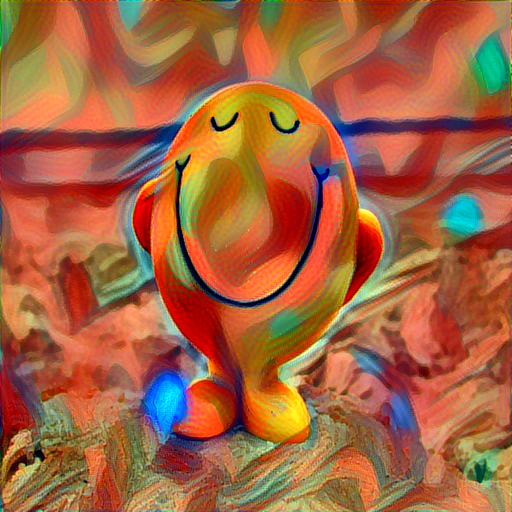

In [50]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)